# LightGBM

- XGBoost와 부스팅 계열 알고리즘에서 가장 각광을 받고 있음

- XGBoost 보다 학습에 걸리는 시간이 훨씬 적음

### LightGBM의 장점
- XGBoost 대비 더 빠른 학습과 예측 수행 시간
- 더 작은 메모리 사용량
- 카테고리형 피처의 자동 변환과 최적 분할
    - 원-핫인코딩 등을 사용하지 않고도 카테고리형 피처를 최적으로 변환하고 이에 따른 노드 분할 수행
    - 수동으로 변환된 데이터를 주입시켜 결과를 확인하고, 변환하지 않은 데이터를 주입해서 결과 비교해볼 필요 있음
    - 수동변환이 더 효율적이라고 알려져 있음

### LightGBM의 단점
- 적은 데이터 세트에 적용할 경우 과적합이 발생하기 쉬움
- 공식 문서상 대략 10,000건 이하의 데이터 세트 : 과대적합이 발생한다고 명시하고 있음

### 기존 GBM과의 차이점
- 일반적인 균형트리분할(Level Wise) 방식과 달리 **`리프중심 트리분할(Leaf Wise)`** 방식을 사용

- 균형트리분할은 최대한 균형 잡힌 트리를 유지하며 분할하여 트리의 깊이를 최소화하여 오버피팅에 강한구조이지만 균형을 맞추기 위한 시간이 필요함
- 리프중심 트리분할의 경우 최대 손실 값을 가지는 리프노드를 지속적으로 분할하면서 트리가 깊어지고 비대칭적으로 생성
    - 이로써 예측 오류 손실을 최소화하고자 함

**사이킷런의 Estimator를 상속받아 fit(), predict() 기반의 학습과 예측, 사이킷런의 다양한 유틸리티 활용 가능**

Light GBM 설치
-아나콘다 프롬프트를 관리자 권한으로 실행 한 후 conda 명령으로 수행
conda install -c conda-forge lightgbm

**윈도우에 설치 시 에러가 발생할 수 있음 - 비주얼스튜디오2019 build tools**

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# 4.0.0부터는 파라미터등의 변경이 많고 판다스 패키지와 충돌이 많으므로 3.3.5사용
!pip install --user lightgbm==3.3.5

In [3]:
import lightgbm
lightgbm.__version__

'3.3.5'

### LightGBM 하이퍼파라미터

- XGBoost와 매우 유사함
- 유의할 점 :
    - 리프 노드가 계속 분할하면서 트리의 깊이가 깊어지므로 이러한 트리 특성에 맞는 하이퍼 파라미터 설정이 필요

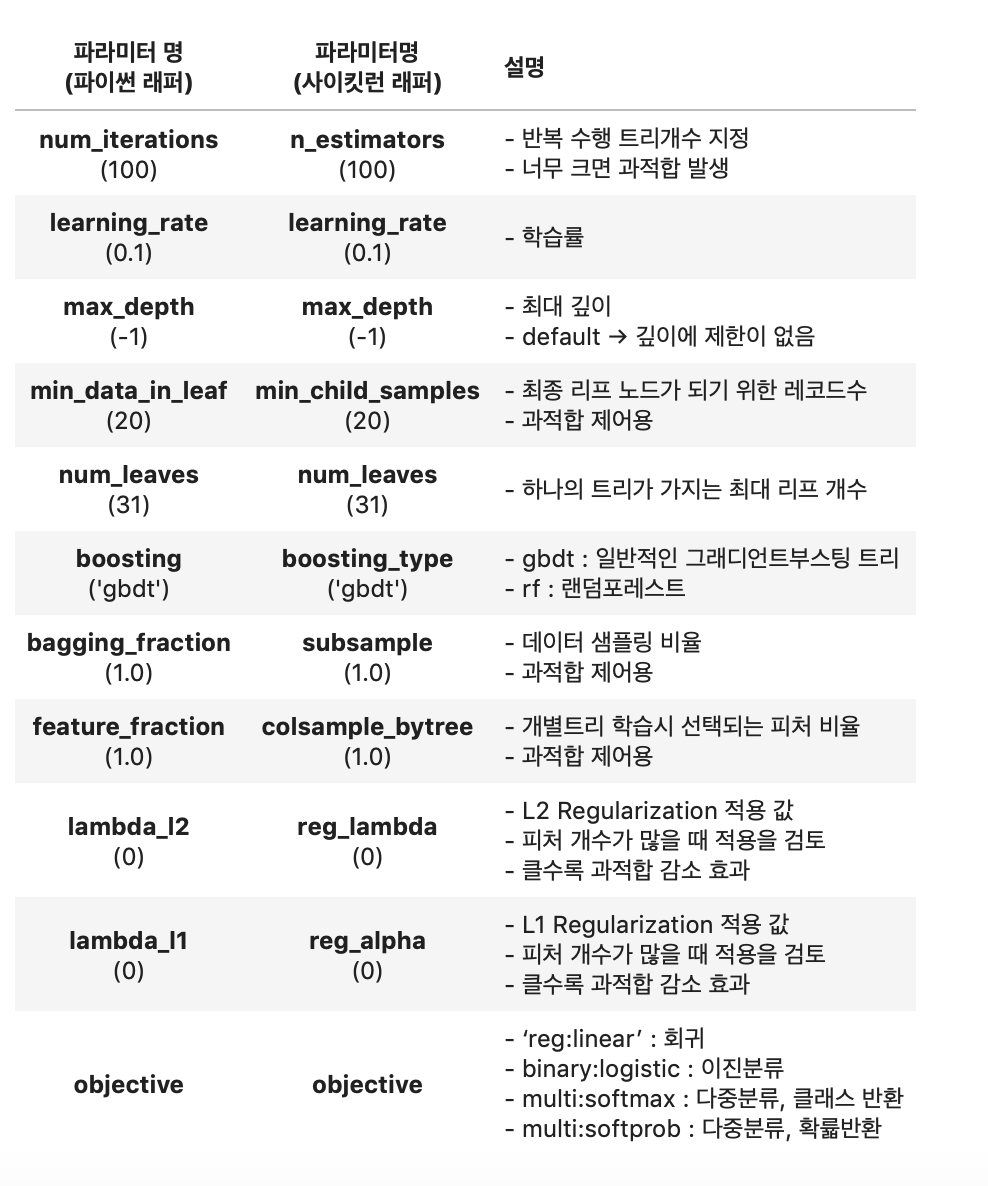

### 하이퍼 파라미터 튜닝 방안

**[방안1] num_leaves 개수를 중심으로 min_child_samples(min_data_in_leaf), max_depth를 함께 조정하면서 모델의 복잡도를 줄이는 것**

- num_leaves는 개별 트리가 가질 수 있는 최대 리프 개수로 LightGBM 모델 복잡도를 제어하는 주요 파라미터
    - num_leaves 개수를 높이면 정확도가 높아지지만, 반대로 트리의 깊이가 깊어지고 모델의 복잡도가 커져 과적합 영향도가 커짐
        
        
- min_data_in_leaf는 사이킷런 래퍼 클래스에서는 min_child_samples로 변경됨
    - 과적합을 개선하기 위한 중요한 파라미터
    - num_leaves와 학습 데이터의 크기에 따라 달라지지만 보통 큰 값으로 설정하면 트리가 깊어짐을 방지함
        
        
- max_depth는 명시적으로 깊이의 크기를 제한함
    - num_leaves, min_data_in_leaf와 결합해 과적합을 개선하는데 사용
    
    
**[방안2] learning_rate를 작게 하면서 n_estimations를 크게 하는 것**
- n_estimators를 너무 크게 하는 것은 과적합으로 오히려 성능이 저하될 수 있으므로 주의



**[방안3] 과적합을 제어하기 위해서 reg_lambda, reg_alpha와 같은 regularization을 적용**


**[방안4] 학습 데이터에 사용할 피처 수나 데이터 샘플링 레코드 개수를 줄이기 위해 colsample_bytree, subsample 파라미터를 적용하는 것도 과적합 제어 방안**

## LightGBM 적용한 위스콘신 유방암 예측
- 데이터의 수가 작기 때문에 과대적합 발생할 가능성 매우 높음
    - 과대적합 방지하기 위한 방안 1을 적용해볼 수 있음
    - 원칙적으로는 위스콘신 데이터는 XGBoost를 사용하는게 좋음
    - 본 실습에서는 예제로만 사용함 (파라미터 튜닝 하지 X)

### LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트

In [4]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

**데이터셋 생성 및 분할**

In [5]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(ftr, target, test_size=0.2, random_state=156 )

### 데이터 분할
- 학습/검증/테스트 데이터로 분할해야 함
    - 단, 현재 데이터(위스콘신)는 light gbm에 적용하기에는 관측치가 너무 적음
    - 학습과 테스트로 분할해서 테스트 데이터를 검증용과 테스트용으로 사용
        - 현업에서는 이렇게 사용하면 X

**학습**

In [6]:
lgbm_wrapper = LGBMClassifier(n_estimators=400)

In [7]:
evals = [(X_test, y_test)]

In [8]:
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100,
                eval_metric='logloss', eval_set=evals, verbose=True)

[1]	valid_0's binary_logloss: 0.565079
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355773
[7]	valid_0's binary_logloss: 0.329587
[8]	valid_0's binary_logloss: 0.308478
[9]	valid_0's binary_logloss: 0.285395
[10]	valid_0's binary_logloss: 0.267055
[11]	valid_0's binary_logloss: 0.252013
[12]	valid_0's binary_logloss: 0.237018
[13]	valid_0's binary_logloss: 0.224756
[14]	valid_0's binary_logloss: 0.213383
[15]	valid_0's binary_logloss: 0.203058
[16]	valid_0's binary_logloss: 0.194015
[17]	valid_0's binary_logloss: 0.186412
[18]	valid_0's binary_logloss: 0.179108
[19]	valid_0's binary_logloss: 0.174004
[20]	valid_0's binary_logloss: 0.167155
[21]	valid_0's binary_logloss: 0.162494
[22]	valid_0's binary_logloss: 0.156886
[23]	valid_0's binary_logloss: 0.152855
[24]	valid_0's binary_logloss: 0.151113
[25]	valid_0's binary_logloss: 0.148395
[26]	vali

LGBMClassifier(n_estimators=400)

In [9]:
early = lightgbm.early_stopping(100)
lgbm_wrapper.fit(X_train, y_train, callbacks=[early],
                eval_metric='logloss', eval_set=evals, verbose=True)

[1]	valid_0's binary_logloss: 0.565079
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355773
[7]	valid_0's binary_logloss: 0.329587
[8]	valid_0's binary_logloss: 0.308478
[9]	valid_0's binary_logloss: 0.285395
[10]	valid_0's binary_logloss: 0.267055
[11]	valid_0's binary_logloss: 0.252013
[12]	valid_0's binary_logloss: 0.237018
[13]	valid_0's binary_logloss: 0.224756
[14]	valid_0's binary_logloss: 0.213383
[15]	valid_0's binary_logloss: 0.203058
[16]	valid_0's binary_logloss: 0.194015
[17]	valid_0's binary_logloss: 0.186412
[18]	valid_0's binary_logloss: 0.179108
[19]	valid_0's binary_logloss: 0.174004
[20]	valid_0's binary_logloss: 0.167155
[21]	valid_0's binary_logloss: 0.162494
[22]	valid_0's binary_logloss: 0.156886
[23]	valid_0's binary_logloss: 0.152855
[24]	valid_0's binary_loglo

LGBMClassifier(n_estimators=400)

- 45번 학습에서 조기종료 결정하고, 설정된 100번을 더 진행한 후에 조기종료됨

In [10]:
# 예측
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [12]:
get_clf_eval(y_test, preds, pred_proba)

# AUC:0.9905 - 분류모델으 평가지표 중 하나, 1이 만점이며 숫자가 클수록 좋은 모델
# 정밀도, 재현율을 모두 포함한 평가 지표

오차 행렬
[[33  4]
 [ 1 76]]
정확도: 0.9561, 정밀도: 0.9500, 재현율: 0.9870,F1: 0.9682, AUC:0.9905


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

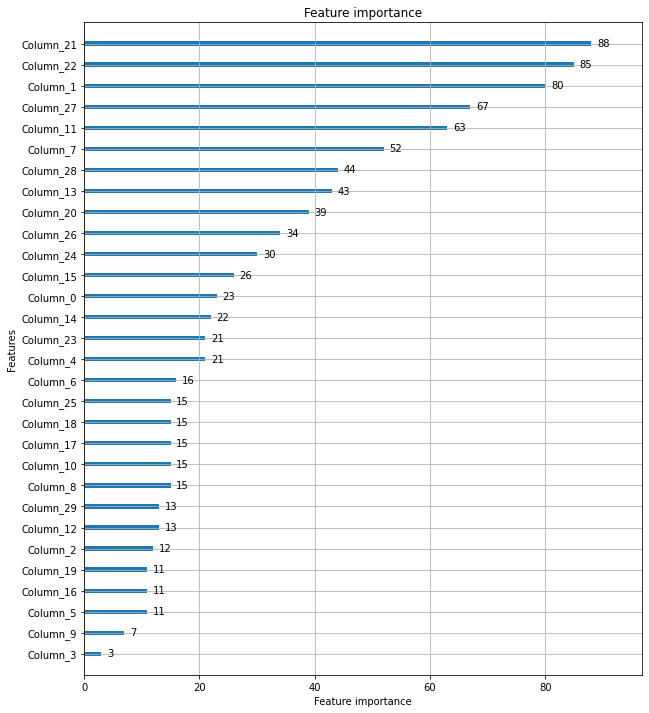

In [13]:
# plot_importance( )를 이용하여 feature 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax=ax, importance_type='split')

# 노트 분할 시 중요하게 사용된 피처를 보여줌

### 머신러닝 모델 알고리즘은 분류와 회귀에 대해 방식이 완전히 나누어져 있지 않고 하나의 방식으로 분류/회귀 모두 가능
- sklearn 패키지는 동일한 알고리즘에 분류와 회귀 모듈을 따로 생성해 놓고 있음
- 단, boosting 계열 알고리즘은 하나의 연결 패키지로 분류/회귀 모두 사용